# Problem Set 4 - SVM, OneVersusOne & Feature Engineering

## CSCI 5622

***
**Name**: Jahoon Koo
***

This assignment is due on Canvas by **11.59 PM on Friday, March 24th**.
Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helpers
import data

# Problem 1: Classification using Support Vector Machines and Kernel Trick (45 points + 4)

We will build SVM for binary classification with the kernel trick and test in on following datasets.

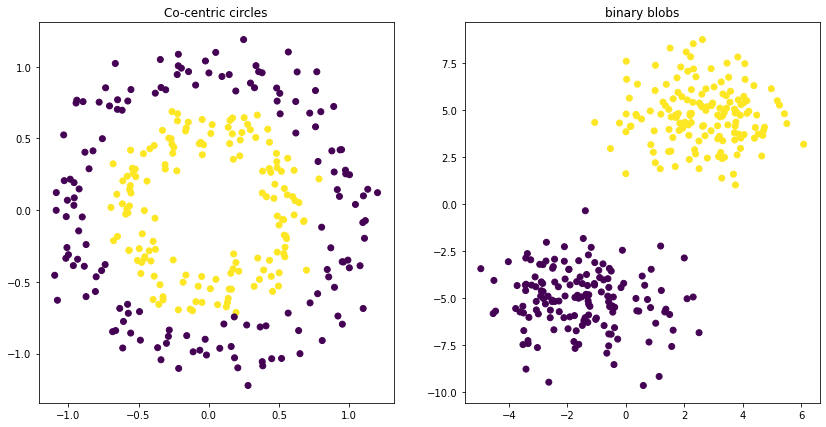

In [2]:
%matplotlib inline
# Do not modify this cell
circles = data.Circles()
binary_blobs = data.DataBlobs(centers=2, std=1.5)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(7), fig.set_figwidth(14)
for i, (dataset, name) in enumerate([(circles, "Co-centric circles"),
                                     (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.labels)
plt.show()

We have seen during the class the dual form of the Support Vector Machine problem using a kernel $K$:

\begin{aligned}
 \max_{\alpha} \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)})
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}

The simplest kernel $K$ is the linear kernel 
\begin{align}
K_{lin}(x^{(i)},x^{(j)}) = <x^{(i)}, x^{(j)}>
\end{align}
 with $<.,.>$ being the scalar product.

 We'll be also using the radial kernel $K_{rad}$:
\begin{align}
 K_{rad, \gamma}(x^{(i)},x^{(j)})  = \exp \big[-\gamma ||x^{(i)} - x^{(j)}||^2]
\end{align}
And the polynomial kernel $K_{poly, c, p}$:
\begin{align}
 K_{poly, c, p}(x^{(i)},x^{(j)})  = (<x^{(i)}, x^{(j)}> + c)^p
\end{align}

**Q1.1 [12 pts]** Complete the implementation of the three kernels defined above

In [3]:
class LinearKernel(object):
    def compute(self, x1, x2):
        """
        Compute the kernel matrix
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = <x1[i], x2[j]>
        """
        # Workspace 1.1.a
        K = np.zeros((x1.shape[0], x2.shape[0]))
        #BEGIN 
        # code here
        for i in range(x1.shape[0]):
            for j in range(x2.shape[0]):
                K[i][j] = np.dot(x1[i], x2[j])
        #END
        return K


class RadialKernel(object):

    def __init__(self, gamma):
        self.gamma = gamma

    def compute(self, x1, x2):
        """
        Compute the kernel matrix. Hint: computing the squared distances is similar to compute_distances in K-means
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = K_rad(x1[i],x2[j]) = exp(-gamma * ||x1[i] - x2[j]||^2)
        """
        # Workspace 1.1.b
        K = np.zeros((x1.shape[0], x2.shape[0]))
        #BEGIN 
        # code here
        for i in range(x1.shape[0]):
            for j in range(x2.shape[0]):
                # chatGPT equation for sqaured distances
                # ||x - y||^2 = (x1 - y1)^2 + (x2 - y2)^2 + ... + (xn - yn)^2
                diff = x1[i] - x2[j]
                squared_distance = np.sum(diff**2)
                K[i][j] = np.exp(-self.gamma * squared_distance)
        #END
        return K


class PolynomialKernel(object):

    def __init__(self, c, p):
        self.c = c
        self.p = p

    def compute(self, x1, x2):
        """
        Compute the kernel matrix.
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = (x1[i].x2[j] + c)^p
        """
        # Workspace 1.1.c
        K = np.zeros((x1.shape[0], x2.shape[0]))
        #BEGIN 
        # code here
        for i in range(x1.shape[0]):
            for j in range(x2.shape[0]):
                K[i][j] = (np.dot(x1[i], x2[j]) + self.c)**self.p
        #END
        return K

In [4]:
%run -i tests kernels

...
----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


<Figure size 432x288 with 0 Axes>

In [5]:
%pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


Now we'll solve for $\alpha$ of the dual form  using the quadratic solver from [`cvxopt` package](https://cvxopt.org/userguide/coneprog.html#quadratic-programming).
To match the solver API, we need to rewrite the problem as:

\begin{aligned}
    \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ Gx \leq h
    \\
    \ Ax = b
\end{aligned}

So we'll define $P, q, G, h, A, b$  as:

\begin{align}
P_{i,j} &= y^{(i)}y^{(j)} K(x^{(i)},x^{(j)}) \text{,  matrix $P$ is of shape $m\times m$}\\
q &= -\overline{1} \text{,  vector of size m} \\
G &= diag(-\overline{1}) = -I_m\text{, diagonal matrix of -1} \\
h &= \overline{0} \text{,  vector of size m} \\
A &= y \text{, the labels vector} \\
b &= 0 \text{, a scalar (not to confuse with the intercept of SVM)}
\end{align}

- **Q1.2 [10 pts]** Complete `quadratic_solver` by defining the different arrays $P, q, G, h, A$ and the scalar $b$. Make sure all arrays are of float type (it is important for `cvxopt`).


In [6]:
from cvxopt import matrix
from cvxopt import solvers
import numpy as np

solvers.options['show_progress'] = False
solvers.options['abstol'] = 1e-10
solvers.options['reltol'] = 1e-10
solvers.options['feastol'] = 1e-10

def quadratic_solver(K, y, beta=0.0):
    """
    Solve for alpha of the dual problem,
    @param K: Kernel matrix K of shape (m,m)
    @param y: labels array y of shape (m,)
    @param beta: added later for the bonus question
    @return: optimal alphas of shape (m,)
    """

    # Workspace 1.2
    m = K.shape[0]
    assert np.allclose([-1, 1], np.unique(y))

    #BEGIN 
    # P = ? shape (m,m)
    P = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            P[i][j] = y[i]*y[j]*K[i][j]
            
    # q = ? # shape(m,1)
    q = -np.ones((m, 1))
    
    # G = ?  # shape(m,m)
    G = np.diag(-np.ones(m))
    
    # h = ? #shape (m,)
    h = np.zeros(m)
    
    # A = ?  # shape (1,m)
    A = y.reshape(1, -1)
    
    # b = ? #scalar
    b = 0.0
    #END
    sol = solvers.qp(P=matrix(P.astype(float)),
                     q=matrix(q.astype(float)),
                     G=matrix(G.astype(float)),
                     h=matrix(h.astype(float)),
                     A=matrix(A.astype(float)),
                     b=matrix(b))
    alphas = np.array(sol['x'])
    alphas = alphas * (np.abs(alphas) > 1e-8)  # zeroing out the small values
    return alphas.reshape(-1)

Once we get the optimal $\alpha$, then we can get the indices of the support vectors $S = \{i | \alpha_i >0 \}$. The intercept $b$ is computed as:

\begin{align}
b = \frac{1}{|S|}\sum_{m\in S}\big[ y^{(m)} - \sum_{i\in S} \alpha_i  y^{(i)}K(x^{(i)}, x^{(m)})\big],
\end{align}
(we only sum over the support vectors, i.e for which $\alpha>0$)



- **Q1.3 [8 pts]** Complete the `compute_intercept` function to implement the equation above given K,$\alpha$ and the labels in {-1,1} (`self.y`)


In [7]:
def compute_intercept(K, alphas, y):

    assert alphas.shape == y.shape
    intercept = 0
    # Workspace 1.3
    #BEGIN 
    # code here
    
    # indices 
    S = np.where(alphas > 0)[0]
    inner_sum = 0
    for i in S:
        inner_sum += alphas[i] * y[i] * K[i][S]
        
    intercept = np.mean(y[S] - inner_sum)
    #END

    return intercept

In SVM, the predicted label for a point $x$ would be:

\begin{align}
\hat{y} = \text{sign}\big[\sum_i y^{(i)}\alpha_i K(x,x^{(i)}) + b \big],
\end{align}
The sum is originally over the support vectors, since for non-support vectors $\alpha=0$ we can sum over the entire training data.

You can see that we only need access to the kernel $K$ and the model is oblivious to the features themselves. That's the power of kernel methods!
- **Q1.4 [5 pts]** Complete the `predict` method to return the predicted labels of the provided samples.

Since our SVM is making predictions of [-1, 1] but convention expects labels of [0,1], we should report out our results in [0,1] format.

In [8]:
class SVM(object):

    def __init__(self, kernel, beta=0.0):
        self.kernel = kernel
        self.X = None
        self.y = None
        self.intercept = None
        self.alphas = None
        self.beta = beta  # ridge regularization coefficient

    def fit(self, X, y):
        """
        Transform y to (-1,1) and use self.kernel to compute K
        Solve for alphas and compute the intercept using the provided expression
        Keep track of X and y since you'll need them for the prediction
        @param X: data points of shape (m,p)
        @param y: (0,1) labels of shape (m,)
        @return: None
        """
        self.X = X
        self.y = 2 * y - 1
        K = self.kernel.compute(X, X)
        self.alphas = quadratic_solver(K, self.y, self.beta)
        self.intercept = compute_intercept(K, self.alphas, self.y)

    def predict(self, X):
        """
        Predict the labels of points in X
        @param X: data points of shape (m,p)
        @return: predicted 0-1 labels of shape (m,)
        """
        # Workspace 1.4
        predicted_labels = np.zeros((X.shape[0],))
        #BEGIN 
        # code here
        for index, x in enumerate(X):
            prediction = 0
            kernel_values = self.kernel.compute(x.reshape(1, -1), self.X)[0]
            for i in range(self.X.shape[0]):
                prediction += self.y[i] * self.alphas[i] * kernel_values[i]
            prediction += self.intercept
            
            predicted_labels[index] = (np.sign(prediction) + 1)/2    
            
        #END
        assert np.allclose(0.5, np.abs(0.5-np.unique(predicted_labels)))
        return predicted_labels

We provide below an example of the expected plots for this problem using the linear kernel. 

- **Q1.5 [4 pts]** Edit the cell to report the accuracy on the test sets for each of the two datasets visualized in the plots. How do you explain the obtained accuracies?

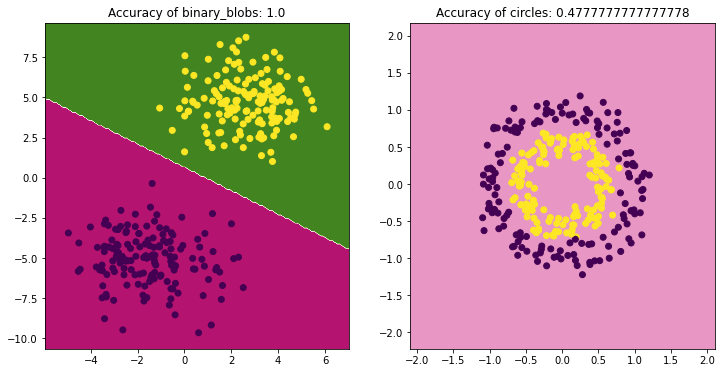

In [9]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
svm_linear = SVM(LinearKernel())
# Workspace 1.5.a
dataset_names = ["binary_blobs", "circles"]
for i, dataset in enumerate([binary_blobs, circles]):
    svm_linear.fit(dataset.X_train, dataset.y_train)
    helpers.show_decision_surface(svm_linear, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN 
    # code here
    predicted_labels = svm_linear.predict(dataset.X_test)
    
    accuracy = 0
    for y, y_hat in zip(dataset.y_test, predicted_labels):
        if y == y_hat:
            accuracy += 1
    accuracy /= len(dataset.y_test)
    axs[i].set_title("Accuracy of {}: {}".format(dataset_names[i], accuracy))
    #END
plt.show()

### Workspace 1.5.b
% Explain the observed performance

#BEGIN

Since binary blobs are linearly separable, the accuracy is 1.0. However, the circles only have accuracy of 0.477 because it's not linearly separable. We might be able to increase the performance by using other kernels that make the dataset linearly separable. 

#END

- **Q1.6 [3 pts]** Plot and report SVM performance the radial kernel with $\gamma=2.0$. Describe the model performance and compare it to the linear kernel.

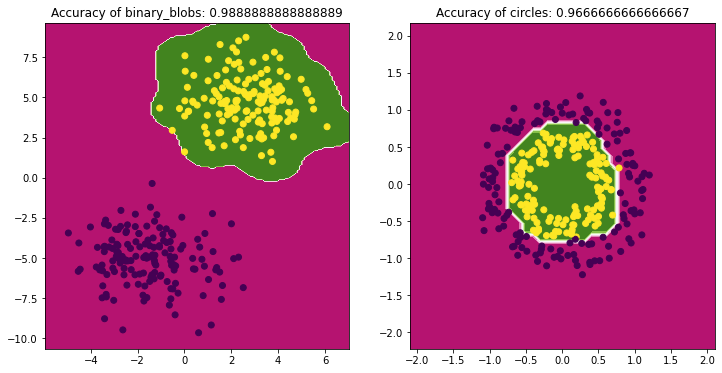

In [10]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 1.6.a
#BEGIN 
# code here
svm_radial = SVM(RadialKernel(gamma=2.0))
dataset_names = ["binary_blobs", "circles"]

for i, dataset in enumerate([binary_blobs, circles]):
    svm_radial.fit(dataset.X_train, dataset.y_train)
    helpers.show_decision_surface(svm_radial, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN 
    # code here
    predicted_labels = svm_radial.predict(dataset.X_test)
    
    accuracy = 0
    for y, y_hat in zip(dataset.y_test, predicted_labels):
        if y == y_hat:
            accuracy += 1
    accuracy /= len(dataset.y_test)
    axs[i].set_title("Accuracy of {}: {}".format(dataset_names[i], accuracy))
plt.show()
#END

### Workspace 1.6.b
% Explain the observed performance

#BEGIN

There is a huge performance improvement with the circles dataset because the radial kernel makes the dataset linearly separable. Accuracy of the binary_blobs dropped by 0.022, but it still has a good performance. 

#END

- **1.7 [3 points]** Plot and report SVM performance on the same datasets as in 2.5 using the polynomial kernel with $(c,p) = (1,5)$. Describe the model performance and compare it to the two previous kernels

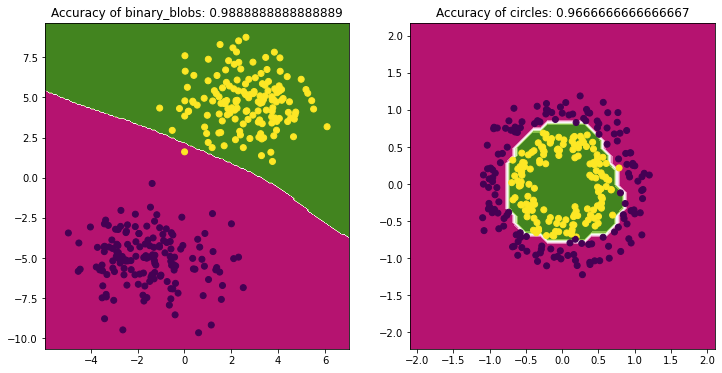

In [11]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 1.7.a
#BEGIN 
# code here
svm_polynomial = SVM(PolynomialKernel(c=1, p=5))
dataset_names = ["binary_blobs", "circles"]

for i, dataset in enumerate([binary_blobs, circles]):
    svm_polynomial.fit(dataset.X_train, dataset.y_train)
    helpers.show_decision_surface(svm_polynomial, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN 
    # code here
    predicted_labels = svm_polynomial.predict(dataset.X_test)
    
    accuracy = 0
    for y, y_hat in zip(dataset.y_test, predicted_labels):
        if y == y_hat:
            accuracy += 1
    accuracy /= len(dataset.y_test)
    axs[i].set_title("Accuracy of {}: {}".format(dataset_names[i], accuracy))
plt.show()

#END

### Workspace 1.7.b
% Explain the observed performance

#BEGIN

Both datasets have the same performance as the radial kernel. The binary_blobs have a decision boundary different than the linear and radial kernel. The circles dataset has an identical decision boundary to the radial kernel.

#END

### Regularization (4 Bonus pts)

We add a ridge regularization of $\alpha$ with coefficient $\beta$, this time there is a minus $-$ since we're maximizing (so that $\beta ||\alpha||^2$ is minimized).
\begin{aligned}
 \max_{\alpha} \Big[ \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)}) - \frac{\beta}{2} ||\alpha||^2 \Big]
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}

**Q1.8 [Bonus, 4pts]** Which elements of the quadratic system $P, q, G, h, A, b$ do we have to Change? Edit **Q3.2** and `SVM` to incorporate `beta` argument.

## Problem 2: SVM for Multiclass Classification (33 Points)
***
You will now create a classifier that is commonly referred to as _One Versus One_ SVM Classifier.
We will use the sklearn's built in Support Vector Classifier ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) for the individual models in this setting.

Given k class labels $\{0,1,2,3.. k-1\}$, we train a classifier for each tuple $(i,j)$ such that $i\neq j$ and $i<j$. We would predict label $i$ if $i$ gets the highest accumulated probability from classifiers that distinguish
between $i$ and each other class $j\neq i$.


- **Q2.0 [3pts]**  Given a dataset with k class labels, how many unique SVC instances do we need to build a OneVersusOne model?

##### Workspace 2.0

#BEGIN

If we need to build a OneVersusOne model for k class labels, we need to build a binary classifier for every pair of distinct class labels, so it would be binomial coefficient. We would need k!/(2!*(k-2)!), which is k(k-1)/2. 

#END


The dataset for this problem will be the same one we used in PS3.

Note that the constant $\beta$ in *1.8* is slightly different from  $C$  in [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and make sure to use the flag `probability` to be able to use `predict_proba`.

- **Q2.1 [3 pts]** Complete `normalize_data` to normalize your features. You can use `StandardScaler`
- **Q2.2 [6 pts]** Complete `predict` method to return the predicted label using the scores from each class classifier.

- **Q2.3 [7 pts]** Complete `fit` function to fit all classifiers with their corresponding labels and compute the WAR at the end of each epoch

Reminder: make no assumption about the number of features/classes in the data.

In [12]:
digits = data.Digits()

In [13]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


class OneVersusOne(object):

    def __init__(self, beta=0):
        self.classifiers = []  # Array of LogisticRegression classifiers
        self.beta = beta  # regularization / penalty rate 
        self.scaler = StandardScaler()
        self.fitted = False  # Flag to store whether the model is already fitted to avoid fitting scaler more than once
        self.models = {}
        self.label_to_index = None
        self.index_to_label = None
        self.num_classes = None

    def normalize_data(self, X):
        """
        Fit scaler if it hasn't been done yet and normalize X
        :param X: Raw features, shape (num_samples, num_features)
        :return: Normalized features,  shape (num_samples, num_features)
        """
        # Workspace 2.1
        # TO DO: Normalize the feature values of dataset X, you have to keep track of the mean and variance
        #BEGIN 
        # code here
        if not self.fitted:
            self.scaler.fit(X)
            self.fitted = True
            
        X = self.scaler.transform(X)
        
        return X
        #END

    def predict(self, X):
        """
        The usual predict method
        """
        # Workspace 2.2
        # TO DO: Normalize X, process it and return the predicted label using the scores from classifiers
        #BEGIN 
        # code here
        X = self.normalize_data(X)
        scores = np.zeros((X.shape[0], self.num_classes))
        
        for i, j in self.models:
            model = self.models[(i, j)]
            predict_proba = model.predict_proba(X)
            scores[:, i] += predict_proba[:, 1]
            scores[:, j] += predict_proba[:, 0]
            
        y_pred = np.argmax(scores, axis=1)
        # Convert indices back to original labels
        y_pred = np.array([self.index_to_label[index] for index in y_pred])
        return y_pred
        #END

    def fit(self, X, y):
        """
        """
        self.label_to_index = dict(zip(np.unique(y), range(len(np.unique(y)))))
        self.index_to_label = {v: k for k, v in self.label_to_index.items()}
        self.num_classes = np.unique(y).shape[0]
        # model i is trained on labels where =1 if class is i and 0 otherwise
        self.models = {(i, j): SVC(C=1 / self.beta, kernel="rbf", probability=True) for i in range(self.num_classes) for j in
                       range(self.num_classes) if i > j}
        # converting labels to index
        y = np.array([self.label_to_index[i] for i in y])

        # Workspace 2.3
        #BEGIN 
        # code here
        X = self.normalize_data(X)
        for i, j in self.models:
            model = self.models[(i, j)]
            indices = np.where((y == i) | (y == j))
            model.fit(X[indices], y[indices])
        
        # code for computing the war in fit function
        # commenting out since we can't calculate the war for validation dataset within the function 
        # unless we modify the parameters

        # y_pred = self.predict(X)
        # war = recall_score(y, y_pred, average='weighted')
        # return war
        #END


- **Q2.4 [5pts]** Plot the curve of Weighted Average Recall (WAR) on the training data and the validation data as $beta$ varies on a log scale.

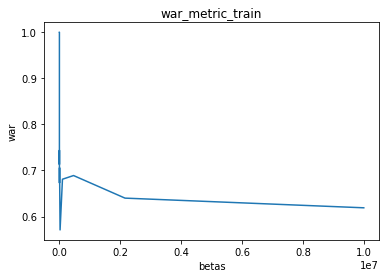

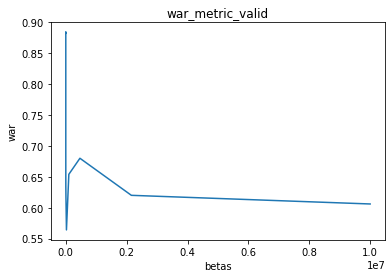

In [14]:
from sklearn.metrics import recall_score

betas = np.logspace(-3, 7, 16)
wars = {"train": [], "valid":[]}
# Workspace 2.4
#BEGIN 
for beta in betas:
    ovo = OneVersusOne(beta)
    ovo.fit(digits.X_train, digits.y_train)
    y_train_pred = ovo.predict(digits.X_train)
    y_valid_pred = ovo.predict(digits.X_valid)
    
    wars["train"].append(recall_score(digits.y_train, y_train_pred, average='weighted'))
    wars["valid"].append(recall_score(digits.y_valid, y_valid_pred, average='weighted'))
    

plt.title("war_metric_train")
plt.xlabel("betas")
plt.ylabel("war")
plt.plot(betas, wars["train"])
plt.show()

plt.title("war_metric_valid")
plt.xlabel("betas")
plt.ylabel("war")
plt.plot(betas, wars["valid"])
plt.show()
#END

- **Q2.5 [5pts]** What is the best value of `beta` for this dataset? What the performance of the model on the test data?

In [15]:
#Workspace 2.5.a
#BEGIN 
# code here
best_beta_train = betas[wars["train"].index(max(wars["train"]))]
best_beta_valid = betas[wars["valid"].index(max(wars["valid"]))]
print("best score for war_metric_training is {} when beta is {}.".format(max(wars["train"]), best_beta_train))
print("best score for war_metric_valid is {} when beta is {}.".format(max(wars["valid"]), best_beta_valid))


ovo = OneVersusOne(best_beta_valid)
ovo.fit(digits.X_train, digits.y_train)
y_test_pred = ovo.predict(digits.X_test)

war_test = recall_score(digits.y_test, y_test_pred, average='weighted')
print("The performance of the model on the test data when beta={} is {}".format(best_beta_valid, war_test))
#END


best score for war_metric_training is 1.0 when beta is 0.001.
best score for war_metric_valid is 0.884 when beta is 0.001.
The performance of the model on the test data when beta=0.001 is 0.886


##### Workspace 2.5.b

#BEGIN

The war score of the model on the test data when beta=0.001 is 0.886.

#END

**Q2.6 [4pts]** What's the relation between $\beta$ and SVC's $C$?

##### Workspace 2.6

#BEGIN

Since C is inversely proportional to the beta rate, C increases as the beta rate decreases. A larger value of C (smaller value of beta) allows the model to have a narrower margin in the SVM. It may have a better performance but may lead to overfitting. A smaller value of C (larger value of beta) will result in a wider margin in the SVM. It can avoid the overfitting problem, but it may lead to underfitting. 

#END

## Problem 3: Feature Engineering (22 points)
So far in all previous problems, we didn't have to worry about creating the features, that is our `X`. We always relied on having it handed to us.
In practical machine learning problems, however, you will have to do some feature engineering yourself in order to get the features matrix `X` before feeding it to the classifier.

For this problem you will work on extracting features from raw data. You will then use scikit-learn [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to complete the classification task.

We will start by importing some libraries and loading our data which contains 2,000 reviews from IMDB along with their sentiment, either positive (`1`) or negative (`0`).

In [25]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jahoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
imdb = data.IMDB()
print(f"[Example: {imdb.X_train[1][:157]}], label:{imdb.y_train[1]}")

[Example: underrated movies are a common reoccurrence in show business today . 1998's 'hope floats' was extremely underrated and was one of the best movies of the year], label:1


Let's call _Featurizer_ any class that is implemented like `StandardScaler` and our initial `MinMaxScaler`. It has:
- a `fit` method that computes any necessary statistics based on our training data (like mean, min or max)
- a `transform` method that generates new features based on given input and the pre-computed statistics
- a `fit_transform` method that combines the two previous methods

We can also combine multiple _Featurizers_ either in a series using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
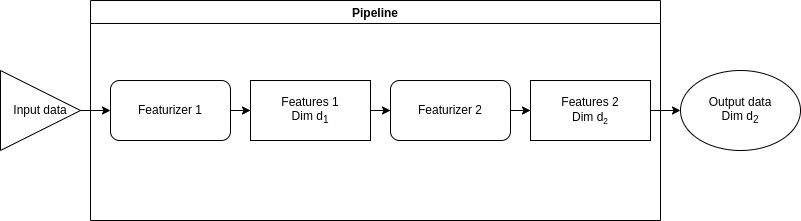
Or in parallel using [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)

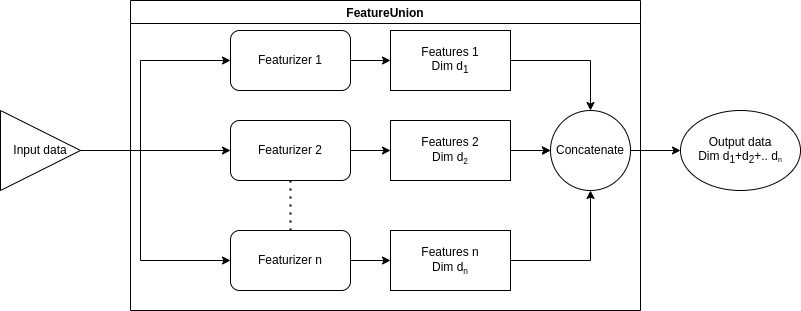

`Pipeline` and `FeatureUnion` are also _Featurizers_.

Both `Pipeline` and `FeatureUnion` take a list of tuples formated as `(features_name: str, featurizer_instance: object)`.

Let's start by extracting some simple features such as the number of sentences in each review.
To do that, we will create a custom scikit-learn feature transformer which will take data as input and returns a feature vector as output.

The feature transformer class has a constructor, a `fit` method. The constructor can be used to store any words or other data that we might need during the feature extraction process.
Feature transformers usually don't need to be fitted, so we will leave that as it is. Most of the work will be done inside the `transform` function.

- 3.1 **[3 points]** Complete the `SentenceCounter` class to extract the number of sentences in each review. 
- 3.2 **[3 points]** Complete the `PunctCounter` class to count the number of "!" and "?" in each review


In [27]:
class SentenceCounter(BaseEstimator, TransformerMixin):
    """
    A custom feature transformer to extract the number of sentences
    """
    def fit(self, data):
        return self

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.1
        # TODO: Transform reviews into the feature (number of sentences)  
        #BEGIN 
        # code here
        for i in range(len(data)):
            # tokenize each sentence 
            features[i] = len(nltk.tokenize.sent_tokenize(data[i]))
        
        #END
        return features


class PunctCounter(SentenceCounter):
    """
    A custom feature transformer to extract the number of "!" and "?"
    """

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.2
        # TODO: Transform reviews into the feature (number of "!" and "?")  
        #BEGIN 
        # code here
        for i in range(len(data)):
            # each sentence 
            features[i] += data[i].count('!')
            features[i] += data[i].count('?')
            
        #END
        return features

The `featurizer` instance below combines `FeatureUnion` and `Pipeline` operations. First, we extract the number of sentences and number of uppercased words, then normalize the two features.

In [28]:
featurizer = Pipeline([("counts", FeatureUnion([('sentences_count', SentenceCounter()),
                                                ('punct_count', PunctCounter())])),
                       ("normalizer", StandardScaler())])
X_train = featurizer.fit_transform(imdb.X_train)
X_test = featurizer.transform(imdb.X_test)
print(f"means:{np.mean(X_train,axis=0)}, Standard deviations:{np.std(X_train, axis=0)}")
print(X_train.shape, X_test.shape)

means:[-5.94762335e-17  2.52179230e-17], Standard deviations:[1. 1.]
(1400, 2) (600, 2)


Let's see how well this simple feature would help us distinguish positive reviews from negative ones.

In [29]:
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.5383333333333333


Not that helpful!

Well, that was expected! let's create more transformers to extract more valuable features.  

- 3.3 **[4 points]** Complete the `NegativeCounter` feature transformer to extract the number of negative words (vocabulary is provided) 

- 3.4 **[4 points]** Complete the `PositiveCounter` feature transformer to extract the number of positive words (vocabulary is provided)

HINT: Before you match the vocabulary words to the review text, use [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html) from `nltk` to convert reviews into tokens. 

In [30]:
class NegativeCounter(SentenceCounter):
    """
    A custom feature transformer to extract the feature "number of negative words" 
    """

    def __init__(self):
        self.neg_words = ["second-rate", "violent", "moronic", "third-rate", "flawed", "juvenile", "boring",
                          "distasteful", "ordinary", "disgusting", "senseless", "static", "brutal", "confused",
                          "disappointing", "bloody", "silly", "tired", "predictable", "stupid", "uninteresting",
                          "weak", "incredibly tiresome", "trite", "uneven", "cliché ridden", "outdated",
                          "dreadful", "bland", "bad", "worst", "waste"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))

        # Workspace 3.3
        # TODO: Transform reviews into the feature (number of negative words)  
        #BEGIN 
        # code here
        
        # convert self.neg_words to a set
        neg_words_set = set(self.neg_words)
        
        for i in range(len(data)):
            words = word_tokenize(data[i])
            for word in words:
                if word in neg_words_set:
                    features[i] += 1
        #END

        return features


class PositiveCounter(NegativeCounter):
    """
    A custom feature transformer to extract the feature "number of positive words"
    """

    def __init__(self):
        self.pos_words = ["first-rate", "insightful", "clever", "charming", "comical", "charismatic", "enjoyable",
                          "uproarious", "original", "tender", "hilarious", "absorbing", "sensitive", "riveting",
                          "intriguing", "powerful", "fascinating", "pleasant", "surprising", "dazzling",
                          "imaginative", "legendary", "unpretentious", "love", "wonderful",
                          "best", "great", "superb", "still", "beautiful"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))

        # Workspace 3.4
        # TODO: Transform reviews into the feature (number of positive words)  
        #BEGIN 
        # code here
        pos_words_set = set(self.pos_words)
        
        for i in range(len(data)):
            words = word_tokenize(data[i])
            for word in words:
                if word in pos_words_set:
                    features[i] += 1
        #END
        return features

Let's see now how well the classifier would perform with these features that we just engineered. 

- 3.5 **[4 points]** Define `second_featurizer` to combine:`num_of_sentences`, `num_of_negative_words`, `num_of_positive_words`, respectively. 

In [31]:
# Workspace 3.5
#BEGIN 
# code here
# second_featurizer = Pipeline([("counts", FeatureUnion([('sentences_count', SentenceCounter()),
#                                                        ('negative_count', NegativeCounter()),
#                                                        ('positive_count', PositiveCounter())])),
#                               ("normalizer", StandardScaler())])
# X_train = second_featurizer.fit_transform(imdb.X_train)
# X_test = second_featurizer.transform(imdb.X_test)
# print(f"means:{np.mean(X_train,axis=0)}, Standard deviations:{np.std(X_train, axis=0)}")
# print(X_train.shape, X_test.shape)

second_featurizer = FeatureUnion([
    ('sentences_count', SentenceCounter()),
    ('negative_count', NegativeCounter()),
    ('positive_count', PositiveCounter())
])


#END

In [32]:
X_train = second_featurizer.fit_transform(imdb.X_train)
X_test = second_featurizer.transform(imdb.X_test)
print(X_train.shape, X_test.shape)
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

(1400, 3) (600, 3)
Accuracy on testing set:  0.675


That's an improvement! Let's try now to include `n-grams` to the list of features.

`N-grams` are all combinations of n-length tokens in a given text. This can be at word level (`word n-grams`) or character level (`char n-grams`) 

For example, if you have the text: `"The movie was great"` , then for this text:

- `unigrams` (`n=1`) at the word level would be `["The", "movie", "was", "great"]` and 
- `bigrams` (`n=2`) at the word level would be `["The movie", "movie was", "was great"]`

and you can generalize this to `n-grams`.

- 3.6 **[4 points]** Define `third_featurizer` to add include an N-gram extractor at the word level.

HINT: use the scikit-learn transformer [`CountVectorizer`](
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [33]:
third_featurizer = FeatureUnion([
    # Workspace 3.6
    # TODO: Add the three feature transformers from 3.5 and a fourth one to extract word n-grams of range  1 to 3
    #BEGIN 
    # code here
    ('sentences_count', SentenceCounter()),
    ('negative_count', NegativeCounter()),
    ('positive_count', PositiveCounter()),
    ('n_gram_extractor', CountVectorizer(ngram_range=(1, 3), analyzer='word'))
    #END
])


Let's now see if adding n-grams helped boost the classifier performance. 

In [34]:
X_train = third_featurizer.fit_transform(imdb.X_train)
X_test = third_featurizer.transform(imdb.X_test)
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.82


N-grams definitely helped enhance the classifier performance!

- 4.7 **(Bonus)** Try to a achieve better accuracy on IMDB dataset. You're restricted to using SGDClassifier, but you're free to tweak its parameters. You'll get 1 bonus point for each 1% accuracy above 82% that you achieve (rounded-up)!

In [41]:
# Workspace 3.7
#BEGIN 
# code here

alphas = [1, 0.1, 0.01, 0.001, 0.0001]
max_iters = [1000, 2000, 4000, 6000, 8000]

best_accuracy = -1 
best_alpha = -1
best_iter = -1
for alpha in alphas:
    for max_iter in max_iters:
        X_train = third_featurizer.fit_transform(imdb.X_train)
        X_test = third_featurizer.transform(imdb.X_test)
        # Train the classifier and find the accuracy on the test dataset
        lr = SGDClassifier(loss='log', penalty='l2', alpha=alpha, max_iter=max_iter, shuffle=True, verbose=0, random_state=42)
        lr.fit(X_train, imdb.y_train)
        y_pred = lr.predict(X_test)
        accuracy = accuracy_score(y_pred, imdb.y_test)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_iter = max_iter
        print("Accuracy on testing set: {} when alpha={} max_iter={}".format(accuracy, alpha, max_iter))
#END

Accuracy on testing set: 0.7816666666666666 when alpha=1 max_iter=1000
Accuracy on testing set: 0.7816666666666666 when alpha=1 max_iter=2000
Accuracy on testing set: 0.7816666666666666 when alpha=1 max_iter=4000
Accuracy on testing set: 0.7816666666666666 when alpha=1 max_iter=6000
Accuracy on testing set: 0.7816666666666666 when alpha=1 max_iter=8000
Accuracy on testing set: 0.8266666666666667 when alpha=0.1 max_iter=1000
Accuracy on testing set: 0.8266666666666667 when alpha=0.1 max_iter=2000
Accuracy on testing set: 0.8266666666666667 when alpha=0.1 max_iter=4000
Accuracy on testing set: 0.8266666666666667 when alpha=0.1 max_iter=6000
Accuracy on testing set: 0.8266666666666667 when alpha=0.1 max_iter=8000
Accuracy on testing set: 0.8233333333333334 when alpha=0.01 max_iter=1000
Accuracy on testing set: 0.8233333333333334 when alpha=0.01 max_iter=2000
Accuracy on testing set: 0.8233333333333334 when alpha=0.01 max_iter=4000
Accuracy on testing set: 0.8233333333333334 when alpha=0.0

In [42]:
print("best accuracy is {}".format(best_accuracy))

best accuracy is 0.8266666666666667
